# AIE Workshop - Julia for Computational Modelling
## Part 4: Matemathical programming with `JuMP.jl`

- **Speaker**: Fabricio Oliveira 
- **Contact**: fabricio.oliveira@aalto.fi | [gamma-opt.aalto.fi](https://gamma-opt.aalto.fi/)

## Example 1 - The Carpenter's problem

A carpenter wants to plan his production of tables and chair such that his income is maximised. Every table 
produced is sold for 1000\$ and every chair produced is sold for 500\$. 

To produce one table, the carpenter needs 3h of work and 7 units of wood. To produce one chair, the carpenter requires 5h of work and 4 units of wood. Weekly, the carpenter has 40h of labour available and 60 units of wood.

### Carpenter's optimisation model

Let $x_t$ be total of tables produced weekly and $x_c$ the total of chairs produced weekly. The total income of the carpenter as a function of $x_t$ and $x_c$ is

$$ z = 800x_t + 600x_c
$$

The carpenter has raw material and labour availability constraints. These can be expressed as

$$\begin{align}
\text{(total hours of labour used) } &3x_t + 5x_c \leq 40 \text{ (total hours of labour available)}\\
\text{(total amount of wood used) } &4x_t + 7x_c \leq 60 \text{ (total amount of wood available)}\\
\end{align}
$$

The mathematical program that maximises the income of the carpenter is given by:

$$
\begin{align}
\text{maximise}_{x_t,x_c} \ &800x_t + 600x_c \\
\text{subject to: } &3x_t + 5x_c \leq 40\\
&4x_t + 7x_c \leq 60\\
&x_t, x_c \geq 0.
\end{align}
$$

In [1]:
using JuMP 
using HiGHS #Awesome open source solver 

m = Model(HiGHS.Optimizer) # Creates a model and informs the solver to be used.

@variable(m, x_t >= 0) # Variable for the total of tables
@variable(m, x_c >= 0) # Variables for the total of chairs

@objective(m, Max, 800*x_t + 600*x_c) # Income function

@constraint(m, 3*x_t + 5*x_c <= 40) # Labour constraint
@constraint(m, 7*x_t + 4*x_c <= 60) # Wood availability constraint

println(m) # Prints the mathematical model

Max 800 x_t + 600 x_c
Subject to
 3 x_t + 5 x_c ≤ 40
 7 x_t + 4 x_c ≤ 60
 x_t ≥ 0
 x_c ≥ 0



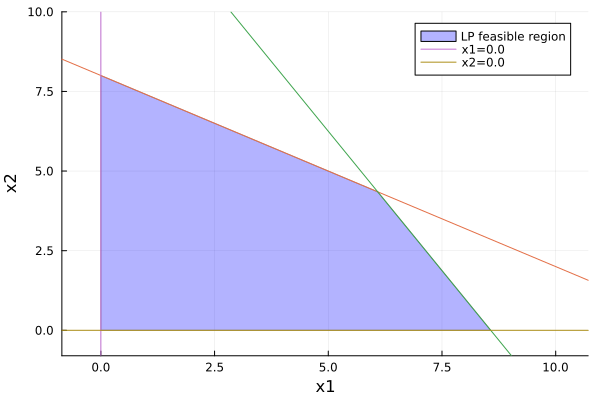

In [2]:
using JuMPModelPlotting # github.com/gamma-opt/JuMPModelPlotting
plot_model(m)

In [3]:
optimize!(m); # Solve the model

println("\n\nOptimal production plan",
        "\n-------------------------",
        "\nTotal of tables: ", round(value.(x_t), digits=2), 
        "\nTotal of chairs: ", round(value.(x_c), digits=2))

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [3e+00, 7e+00]
  Cost   [6e+02, 8e+02]
  Bound  [0e+00, 0e+00]
  RHS    [4e+01, 6e+01]
Presolving model
2 rows, 2 cols, 4 nonzeros  0s
2 rows, 2 cols, 4 nonzeros  0s
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -3.4999972583e+02 Ph1: 2(4.75); Du: 2(350) 0s
          2     7.4782608696e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  7.4782608696e+03
HiGHS run time      :          0.00


Optimal production plan
-------------------------
Total of tables: 6.09
Total of chairs: 4.35


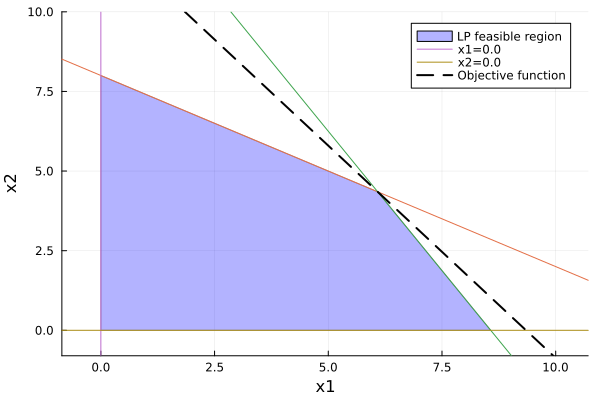

In [4]:
plot_model(m)

# Example 2 - The distribution planning problem

We have to plan the distribution of a given product. The objective is to minimise the transportation costs, while observing capacity limitations of the factories and that all clients have their demand  fully met.

The table below summarises the capacities, demands, and transportation costs between factories and clients.

|              |  Clients  |          |        |       |             
| ---------    | --------- | -------- | ------ | ----- |
| **Factory**  |New York   | Chicago  | Miami  | **Capacity**|
|Seattle       | 2.5       | 1.7      | 1.8    | 350   |
|San Diego     | 3.5       | 1.9      | 1.4    | 600   |
| **Demands**  | 325       | 300      | 275    | -     |

### Optimal distribution plan
Let $i \in I = \{\text{Seattle}, \text{San Diego}\}$ be the index representing factories (that is, $i=1$ refers to Seattle, $i=2$ refers to San Diego). Similarly, let $j \in J = \{\text{New York}, \text{Chicago}, \text{Miami}\}$.

Let $x_{ij}$ be the total amount produced in factory $i$ and sent to client $j$. 

The total distribution cost is given by

$$ 2.5x_{11} + 1.7x_{12} + 1.8x_{13} + 3.5x_{21} + 1.9x_{22} + 1.4x_{23},
$$

which can be more compactly expressed as 

$$\sum_{i \in I}\sum_{j \in J}x_{ij}.$$

The capacity limitation constraints must be enforced for each plant:

$$\begin{align}
\text{(total production from Seattle) } &x_{11} + x_{12} + x_{13} \leq 350 \text{ (total capacity in Seattle)}\\
\text{(total production from San Diego) } &x_{21} + x_{22} + x_{23} \leq 600 \text{ (total capacity in San Diego)}.
\end{align}
$$

These constraints can be expressed in the more compact form

$$ \sum_{j \in J} x_{ij} \leq C_i, \forall i,$$

where $C_i$ is the production capacity of factory $i$.

The demand fulfillment constraints must be enforced for each client:

$$\begin{align}
\text{(total of products in New York) } &x_{11} + x_{21} \geq 325 \text{ (total demand in New York)}\\
\text{(total of products in Chicago) } &x_{12} + x_{22} \geq 300 \text{ (total demand in Chicago)}\\
\text{(total of products in Miami) } &x_{13} + x_{23} \geq 275 \text{ (total demand in Miami)}.
\end{align}
$$

More compactly:

$$\sum_{i \in I} x_{ij} \geq D_j, \forall j,$$

where $D_j$ is the demand of client $j$.

The mathematical program that minimises the production and transportation costs is given by

$$
\begin{align}
\text{minimise}_{x_{11},\dots,x_{23}} \ &2.5x_{11} + 1.7x_{12} + 1.8x_{13} + 3.5x_{21} + 1.9x_{22} + 1.4x_{23} \\
\text{subject to: } &x_{11} + x_{12} + x_{13} \leq 350\\
&x_{21} + x_{22} + x_{23} \leq 600\\
&x_{11} + x_{21} \geq 325\\
&x_{12} + x_{22} \geq 300\\
&x_{13} + x_{23} \geq 275\\
&x_{11}, \dots, x_{23} \geq 0.
\end{align}
$$

Or, more compactly

$$
\begin{align}
\text{minimise}_{x_{ij}}\ &\sum_{i \in I}\sum_{j \in J}x_{ij}\\
\text{subject to: } & \sum_{j \in J} x_{ij} \leq C_i, \ \forall i \in I\\
& \sum_{i \in I} x_{ij} \geq D_j, \ \forall j \in J\\
&x_{ij} \geq 0, \ \forall i \in I, \ \forall j \in J.
\end{align}
$$

In [5]:
using JuMP, HiGHS

# Problem data

I = 1:2           # i=1: Seattle; i=2: San Diego 
J = 1:3           # j=1: New York; j=2: Chicago; j=3: Miami 

C = [350 600]     # Capacities of the factories

D = [325 300 275] # Demand of clients

T = [2.5 1.7 1.8;
     3.5 1.9 1.4]; # Transportation costs

In [6]:
# Model implementation

m = Model(HiGHS.Optimizer) # Creates a model and informs the solver to be used.

@variable(m, x[i ∈ I, j ∈ J] >= 0)                                     # Variable for the total transported

@objective(m, Min, sum(T[i,j]*x[i,j] for i ∈ I, j ∈ J))       # Distribution cost

@constraint(m, cap[i ∈ I], sum(x[i,j] for j ∈ J) ≤ C[i]) # Capacity constraint
@constraint(m, dem[j ∈ J], sum(x[i,j] for i ∈ I) ≥ D[j]) # Demand constraint

println(m)      

Min 2.5 x[1,1] + 1.7 x[1,2] + 1.8 x[1,3] + 3.5 x[2,1] + 1.9 x[2,2] + 1.4 x[2,3]
Subject to
 dem[1] : x[1,1] + x[2,1] ≥ 325
 dem[2] : x[1,2] + x[2,2] ≥ 300
 dem[3] : x[1,3] + x[2,3] ≥ 275
 cap[1] : x[1,1] + x[1,2] + x[1,3] ≤ 350
 cap[2] : x[2,1] + x[2,2] + x[2,3] ≤ 600
 x[1,1] ≥ 0
 x[2,1] ≥ 0
 x[1,2] ≥ 0
 x[2,2] ≥ 0
 x[1,3] ≥ 0
 x[2,3] ≥ 0



In [7]:
optimize!(m) # Solve the model
println("\nDistribution plan: \n", value.(x))

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+00, 4e+00]
  Bound  [0e+00, 0e+00]
  RHS    [3e+02, 6e+02]
Presolving model
5 rows, 6 cols, 12 nonzeros  0s
5 rows, 6 cols, 12 nonzeros  0s
Presolve : Reductions: rows 5(-0); columns 6(-0); elements 12(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 3(900) 0s
          4     1.7625000000e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  1.7625000000e+03
HiGHS run time      :          0.00

Distribution plan: 
2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:2
    Dimension 2, 1:3
And data, a 2×3 Matrix{Float64}:
 325.0   25.0    0.0
   0.0  275.0  275.0


Let's what happens for large (more realistic) problems. The code below implements the same model as before, but using arbitrary numbers of client and factories, set as $M$ and $N$, respectively. 

To calculate the costs, we use the Euclidean distance between points that have their coordinates randomly generated. We randomly generate $M+N$ points, assuming that the first $M$ are clients and the last $N$ are factories. 

In [8]:
using Random
M = 150 # factories
N = 300 # clients
 
I = 1:M
J = 1:N

x_coord = 1000*rand(M+N)
y_coord = 1000*rand(M+N)

C = 30*rand(M) # factory capacity
D = 10*rand(N) # client demand

T = zeros(M,N) # cost 

# Calculate the (Euclidean) distance between nodes based on their coordinates
for i = 1:M
    for j = 1:N
        T[i,j] = 10*sqrt((x_coord[i] - x_coord[j+M])^2 + 
            (y_coord[i] - y_coord[j+M])^2)
    end
end

# In case the random capacities add to be less than the demand, we add the difference to the last node.
if sum(C) < sum(D)
    println("Capacity has been adjusted to obtain feasibility.\n")
    C[N] = C[N] + sum(D) - sum(C)
end

In [9]:
# Model implementation

m = Model(HiGHS.Optimizer) # Creates a model and informs the solver to be used.

@variable(m, x[i ∈ I, j ∈ J] >= 0)                                     # Variable for the total transported

@objective(m, Min, sum(T[i,j]*x[i,j] for i ∈ I, j ∈ J))       # Distribution cost

@constraint(m, cap[i ∈ I], sum(x[i,j] for j ∈ J) ≤ C[i]) # Capacity constraint
@constraint(m, dem[j ∈ J], sum(x[i,j] for i ∈ I) ≥ D[j]) # Demand constraint

println(m)   # Prints the mathematical model (at your own risk!)

Min 2305.940976954315 x[1,1] + 2755.38396902481 x[1,2] + 4726.597106926761 x[1,3] + 3272.5428902060567 x[1,4] + 5378.134919144928 x[1,5] + 6057.6919749469835 x[1,6] + 2005.0443865111495 x[1,7] + 4329.667388918579 x[1,8] + 4070.503997438207 x[1,9] + 4042.3935828420827 x[1,10] + 3618.584618570687 x[1,11] + 7403.582917208149 x[1,12] + 6272.236392351419 x[1,13] + 4201.1205624239155 x[1,14] + 5492.139210466458 x[1,15] + 1309.1078421237628 x[1,16] + 1578.8878867022072 x[1,17] + 1778.858017818951 x[1,18] + 4169.658869712165 x[1,19] + 5627.446389313151 x[1,20] + 2909.931858096918 x[1,21] + 2921.9757141952587 x[1,22] + 3611.8145091970528 x[1,23] + 6563.261454702917 x[1,24] + 5166.482278762087 x[1,25] + 2076.7288244867186 x[1,26] + 642.8664805282124 x[1,27] + 4704.171247876344 x[1,28] + 6270.083006638035 x[1,29] + 3589.256177439775 x[1,30] + [[...44940 terms omitted...]] + 5259.950390578138 x[150,271] + 2615.133406140937 x[150,272] + 6869.332206001908 x[150,273] + 3856.2429415644237 x[150,274] +

In [10]:
optimize!(m) # Solve the model

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 1e+04]
  Bound  [0e+00, 0e+00]
  RHS    [5e-02, 3e+01]
Presolving model
450 rows, 45000 cols, 90000 nonzeros  0s
450 rows, 45000 cols, 90000 nonzeros  0s
Presolve : Reductions: rows 450(-0); columns 45000(-0); elements 90000(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 300(1538.06) 0s
        606     8.5782745042e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 606
Objective value     :  8.5782745042e+05
HiGHS run time      :          0.05


The code below plots a graph for the instance that was randomly generated.

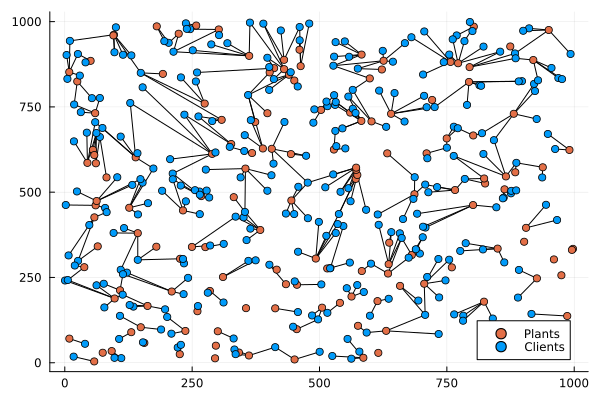

In [11]:
# This code plots a graph with the randomly generated instance and its solution.
using Plots

plot()

for i=1:M
    for j=1:N
        if value(x[i,j]) > 0.0
            plot!([x_coord[i],x_coord[j+M]],[y_coord[i], y_coord[j+M]], color=:black, label="")
        end
    end
end

scatter!(x_coord[1:M], y_coord[1:M], label = "Plants", color = :2)
scatter!(x_coord[M+1:M+N], y_coord[M+1:M+N], label = "Clients", color = :1, legend=true)

# Example 3 - Power system expansion planning

In [12]:
## Packages used
using Statistics
using CSV
using Plots
using HiGHS 
using JuMP
using Combinatorics

## Problem description

We consider a model that defines optimal generation and transmission capacity such that both investments and operational costs are minimised. There are 5 technologies to be chosen from, in 5 distinct nodes, each with its own demand and wind availability profiles. 

Our objective is to find an optimal generation and transmission deployment that is optimal in terms of cost while staisfying demand constraints and other related technical constraints. The picture below illustrates our system.

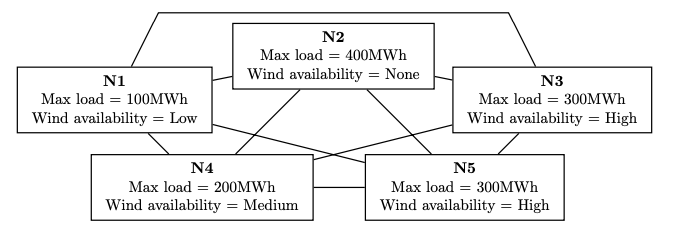

## Data input

The following cells perform the data processing to get the data into the format to be used in the model formulation.

In [13]:
function read_input_data()
    cd(joinpath(pwd(),"Data"))            # Change the workind directory to the folder named Data
    nodes = 5
    demand_data = zeros(nodes, 24, 4, 3)  # Dimensions: (node, hour, season, scenario)
    wind_data = zeros(nodes, 24, 4, 3)
    
    for i in 1:nodes                 # Nodes
        for j in 1:4                 # Seasons
            n = ["N1", "N2", "N3", "N4", "N5"][i]              # Header for nodes
            s = ["Winter", "Spring", "Summer", "Autumn"][j]    # Header for seasons
            df_aux = CSV.File(string("D_", n, "_", s, ".csv")) # Read relative csv file
            demand_data[i,:,j,1] = df_aux.Min                  # Retrieve specific columns (.column_name)
            demand_data[i,:,j,2] = df_aux.Mean
            demand_data[i,:,j,3] = df_aux.Max
            
            df_aux = CSV.File(string("W_", n, "_", s, ".csv")) # Read relative csv file
            wind_data[i,:,j,1] = df_aux.Min
            wind_data[i,:,j,2] = df_aux.Mean
            wind_data[i,:,j,3] = df_aux.Max
        end
    end
    cd("..")
    
    return demand_data, wind_data
end

read_input_data (generic function with 1 method)

In [14]:
## We can now allocate the appropriate data values to an array to be used in the model formulation.
demand, wind = read_input_data();

D = zeros(5,24,4)                    # Create the demand matrix for the deterministic case; dimensions: (node, hour, season)
W = zeros(5,24,4)                    # Create the wind availability factor matrix for the deterministic case
max_load = [100, 400, 300, 200, 300] # The demand data is originally normalised based on a maximum load (in MW) for the location. 

for i in 1:5
    for j in 1:4
        ## The demand considered is equal to the normalised demand of the node times its maximum load.
        D[i,:,j] = max_load[i] .* demand[i,:,j,2]; # 2 => mean value 

        ## Wind availability is a value ranging from 0 to 1 denoting how much of the 
        ## available generation capacity can be used in each node per hour per season
        W[i,:,j] = wind[i,:,j,2]; # 2 => mean value
    end
end

The cell below shows in a plot all the demand profiles taking into account the maximum loads for each node.

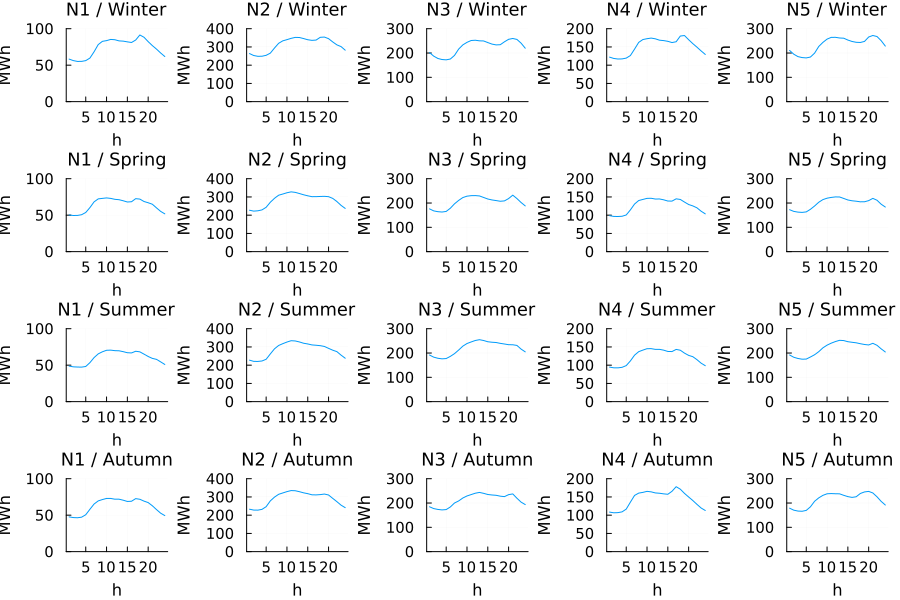

In [15]:
p = Array{Any}(undef,(5,4))
for i in 1:5, j in 1:4
    p[i,j] = plot(D[i,:,j], # replace D[i,:,j] with max_load[i] .* demand[i,:,j,:] to also plot min and max
        legend = false,
        size = (900,600),
        xtickfontsize=10,ytickfontsize=10,titlefontsize = 12,
        ylims = (0,max_load[i]),
        gridlinewidth = 0.1,
        xlabel = "h",
        ylabel = "MWh"
    )
    n = ["N1","N2","N3","N4","N5"][i]
    s = ["Winter","Spring","Summer","Autumn"][j]
    title!("$n / $s")
    # hline!([0],line = (:white, 1))
    if i == 2 || i == 3 || i == 5
        yticks!(0:100:max_load[i])
    else
        yticks!(0:50:max_load[i])
    end
end

plot(p..., layout = (4,5), legend=false)

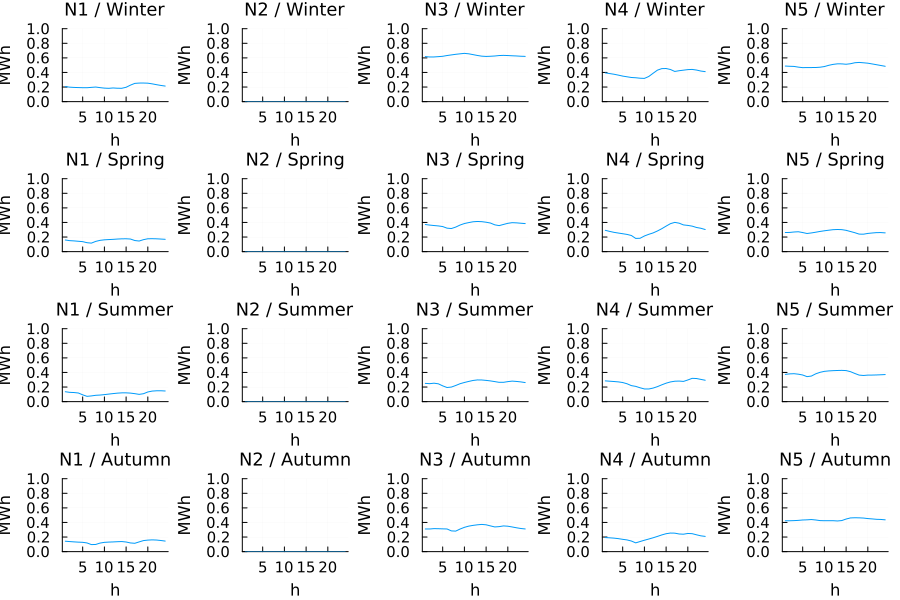

In [16]:
p = Array{Any}(undef,(5,4))
for i in 1:5, j in 1:4
    p[i,j] = plot(W[i,:,j], # replace W[i,:,j] with wind[i,:,j,:] to also plot min and max
        legend = false,
        size = (900,600),
        xtickfontsize=10,ytickfontsize=10,titlefontsize = 12,
        ylims = (0,1),
        gridlinewidth = 0.1,
        xlabel = "h",
        ylabel = "MWh"
    )
    n = ["N1","N2","N3","N4","N5"][i]
    s = ["Winter","Spring","Summer","Autumn"][j]
    title!("$n / $s")
#     hline!([0],line = (:white, 1))
#     if i == 2 || i == 3 || i == 5
#         yticks!(0:100:max_load[i])
#     else
#         yticks!(0:50:max_load[i])
#     end
end

plot(p..., layout = (4,5), legend=false)

## Model formulation

**Sets**
- $H$ - set of hours
- $S$ - set of seasons
- $T$ - set of geenration technologies
- $N$ - set of nodes
- $L$ - set of lines

**Parameters** (input data)
- $K$ - Annualised generation investment cost [k€/MW]
- $KT$ - Annualised transmission investment cost [k€/MW]
- $KA$ - Generation maintenance cost [k€/MW]
- $KAT$ - Transmission maintenance cost [k€/MW]
- $CO$ - Generation operational cost [k€/MWh]
- $COT$ - Transmission operational cost [k€/MWh]
- $CS$ - Shedding cost [k€/MWh]
- $ShC$ - Sheddign limit 
- $RES$ - Minimum renewable energy share
- $GCN$ - Existing generation capacity [MW]

**Decision variables**
- $p_{t,h,n,s} \ge 0$ - Generation level [MWh]
- $p^{max}_{t,n} \ge 0$ - Additional generation capacity [MW]
- $q_{h,n,s} \ge 0$ - Load shedding [MWh]
- $f_{h, l, s}$ - Transmission (direct if positive, reverse otherwise) [MWh]
- $f^{abs}_{h,l,s} \ge 0$ - Auxiliary variable for calculating $|f_{h,l,s}|$
- $f^{max}_{l} \ge 0$ - Additional transmission capac. of t [MW]


The complete optimisation model can be stated as

\begin{align}
    \text{minimise } &\sum_{n \in N} \sum_{t \in T} \left( K_tp^{max}_{t,n} + KA_t(p_{t,n}^{max} + GCN_{t,n}) \right) + \nonumber \\
    & \sum_{t \in T}\sum_{s \in S}\sum_{n \in N}\sum_{h \in H} CO_t p_{t,h,n,s} SS_s \nonumber + \nonumber \\
    & \sum_{l \in L} (KT_l + KAT)f_l^{max} + \nonumber \\ 
    & \sum_{s \in S}\sum_{l \in L} \sum_{h \in H} COT f_{h,l,s}^{abs} SS_s + \nonumber \\ 
    & \sum_{s \in S}\sum_{n \in N} \sum_{h \in H} CS q_{h,n,s} SS_s \\
    \text{subject to:} & \\ 
    & q_{h,n,s} + \sum_{t \in T} p_{t,h,n,s} + \sum_{l \in L : l(i) = n} f_{h,l,s} = D_{n,h,s} + \sum_{l \in L : l(j) = n} f_{h,l,s}, \ \forall h \in H, n \in N, s \in S \\ 
    & p_{t,h,n,s} \le W_{n,h,s}(p_{t,n}^{max} + GCN_{t,n}), \ t = 1, \forall h \in H, n \in N, s \in S \\
    & p_{t,h,n,s} \le p_{t,n}^{max} + GCN_{t,n}, \ \forall t: t \neq 1, h \in H, n \in N, s \in S \\
    & \sum_{h \in H} \sum_{n \in N} \sum_{s \in S} p_{1,h,n,s} SS_s \ge RES \\ 
    & \sum_{t \in T}\sum_{h \in H} \sum_{n \in N} \sum_{s \in S}p_{1,h,n,s} SS_s \\ 
    & q_{h,n,s} \le ShC D_{n,h,s}, \ \forall h \in H, n \in N, s \in S \\ 
    & f_l^{max} \ge f_{h,l,s}, \ \forall h \in H, n \in N, s \in S \\ 
    & f_l^{max} \ge -f_{h,l,s}, \ \forall h \in H, n \in N, s \in S \\ 
    & f_{h,l,s}^{abs} \ge f_{h,l,s}, \ \forall h \in H, n \in N, s \in S \\ 
    & f_{h,l,s}^{abs} \ge -f_{h,l,s}, \ \forall h \in H, n \in N, s \in S.
\end{align}

In [19]:
## Data input
## Sets
nodes = 5                 # Number of nodes considered           
lines = 10;               # Number of transmission lines

H = 1:24                      # Hours in the day {1,...,24} (time periods in the model in each representative day)
S = 1:4                       # Seasons: 1 = "Winter", 2 = "Spring", 3 = "Summer", 4 = "Autumn"
T = 1:5                       # Generation Technologies: # 1: Wind, 2: Nuclear; 3: Coal, 4: Gas OCGT, 5: Gas CCGT
N = 1:nodes                   # Nodes set
L = combinations(1:nodes,2)   # Lines set (list of tuples [i,j]) - generate all combinations (i,j) once
SS = [92, 91, 91, 91]                  # Number of days in each season (used to calculate costs correctly)

## Parameters (energy generation)
KI = [1500.0, 3000.0, 1000.0, 500.0, 800.0]      # Generation investment cost [k€/MW]
LT = [25, 30, 40, 40, 50]                        # Generation technology lifetime [years]
K = zeros(length(KI))                            
for i in 1:length(KI)
    K[i] = KI[i] * 0.05 / (1-(1.05^-LT[i]))      # Annualized generation investment cost (interest rate of 5% pa)[k€/MW]
end

KA = [60.0 50.0 48.0 10.0 16.0]                  # Generation maintenance cost [k€/MW]
CO = [0.1 6.2 13 23 20]/1000                     # Generation operational cost [k€/MWh]

CS  = 1.0                                        # Shedding cost [k€/MWh]
ShC = 0.1                                        # Shedding limit [% of demand]
RES = 0.25                                       # Mininum renewable energy share (for all nodes)

## Existing generation capacity (t: technologies x n: nodes); N1 and N2 start with initial nuclear capacity. 
GCN = [0 0 0 0 0 ;                  
30.0 60.0 0 0 0 ;
0 0 0 0 0 ;
0 0 0 0 0 ;
0 0 0 0 0]

## Parameters (transmission)
KIT  = 0.5                                                  # Line investment cost (also per km) [k€/MW.km]
dist = [200, 400, 300,                                      # Length in km of each line (i.e, [1,2], [1,3]..., [4,5], in order) 
        800, 200, 700,                                      # (see L defined above for the full ordering if necessary)
        500, 750, 350, 180] 
LT_T = 40                                                    # Transmission line lifetime [years]
KT  = Dict(L .=> (KIT * dist) * 0.05 / (1 - (1.05^(-LT_T)))) # Annualized transmission investment cost (interest rate of 5% pa)[k€/MW]      
KAT = 0.01                                                   # Transmission maintenance cost [k€/MW] 
COT = 10^-4;                                                 # Transmission operational cost [k€/MWh]

In [17]:
function solve_det(D, W, SS, H, S, T, N, L, GCN, RES, CS, ShC, K, KA, CO, KT, KAT, COT)
    
    ## Variables
    opt_model = Model(HiGHS.Optimizer)

    @variable(opt_model, p[t in T, h in H, n in N, s in S] >= 0)  # Generation level in each hour by t [MWh]
    @variable(opt_model, p_max[t in T, n in N] >= 0)              # Additional generation capac. of t [MW]
    @variable(opt_model, q[h in H, n in N, s in S] >= 0)          # Energy shedding in h [MWh]
    @variable(opt_model, f[h in H, l in L, s in S])               # Transmission flow in each hour by t [MWh]
    @variable(opt_model, f_abs[h in H, l in L, s in S] >= 0)      # Auxiliary variable for calculating |f[h,l,s]|
    @variable(opt_model, f_max[l in L] >= 0)                      # Additional transmission capac. of t [MW]
    
    ## Objective function: total system cost comprised of:
    ## 1. Generation capacity investment costs (fixed and variable)
    ## 2. Generation operational costs
    ## 3. Transmission capacity investment costs
    ## 4. Transmission operational costs
    ## 5. Shedding costs
    @objective(opt_model, Min, 
        sum((K[t] + KA[t]) * p_max[t,n] for t in T, n in N) 
        + sum(CO[t] * p[t,h,n,s] * SS[s] for t in T, h in H, n in N, s in S)
        + sum((KT[l] + KAT) * f_max[l] for l in L)
        + sum(COT * f_abs[h,l,s] * SS[s] for h in H, l in L, s in S)
        + sum(CS * q[h,n,s] * SS[s] for h in H,n in N, s in S))

    ## Constraints
    ## 1) Energy balance: at each node, hour and season the total generation of electricity plus electricity input from
    ## transmission has to be the same as the electricity used to satisfy the demand (minus the shedding amount) plus the electricity output for transmission
    @constraint(opt_model, c1[h in H, n in N, s in S],
        sum(p[t,h,n,s] for t in T)  
        - sum(f[h,l,s] for l in L if l[1] == n) 
        + sum(f[h,l,s] for l in L if l[2] == n)
        == D[n,h,s] - q[h,n,s])

    ## 2) Renewable (wind) generation capacity: wind generation is limited by the available capacity (pre-existent + build) times the 
    ## wind availability factor.
    @constraint(opt_model, c2[t in [1], h in H, n in N, s in S],
        p[t,h,n,s] <= W[n,h,s] * (p_max[t,n] + GCN[t,n]))

    ## 3) Nonrenewable generation capacity: electricity generation cannot be greater than available capacity (pre-existent + build)
    @constraint(opt_model, c3[t in T[T.>1], h in H, n in N, s in S],
        p[t,h,n,s] <= p_max[t,n] + GCN[t,n])

    ## 4) Minimum renewable energy generation: a certain percentage (RES) of the total electricity generation has to be done by renewable sources
    @constraint(opt_model, c4,
        sum(p[1,h,n,s] for h in H, n in N, s in S) >=
        RES * sum(p[t,h,n,s] for t in T, h in H, n in N, s in S))

    ## 5) Shedding limit: at any given hour, the total demand shed cannot exceed a fration (ShC) of the demand.
    @constraint(opt_model, c5[h in H, n in N, s in S],
        q[h,n,s] <= ShC * D[n,h,s])

    ## 6) Transmission capacity: the total energy transmitted cannot exceed the transmission capacity. Both direct (+) and inverse (-) flows 
    ## are subject to capacity limitations.
    @constraint(opt_model, c6_1[h in H, l in L, s in S],
        f[h,l,s] <= f_max[l])

    @constraint(opt_model, c6_2[h in H, l in L, s in S],
        -f_max[l] <= f[h,l,s]);

    ## 7 ) Absolute value of f[h,l,s]: a linearisation of the absolute value function must be performed to the correct value of the flow
    ## is captured in the objective function. 
    @constraint(opt_model, c7_1[h in H, l in L, s in S], 
        f_abs[h,l,s] >= f[h,l,s])
   
    @constraint(opt_model, c7_2[h in H, l in L, s in S], 
        f_abs[h,l,s] >= -f[h,l,s])   
    
    optimize!(opt_model)

    ## Storing the solution in Arrays
    sol_p_max = value.(p_max).data
    sol_p = value.(p).data
    sol_q = value.(q).data
    sol_f_max = value.(f_max).data
    sol_f = value.(f).data
    sol_OF = objective_value(opt_model);

    # The dual of the energy balance constraint gives us the marginal value of satisfying one extra unit of demand, i.e., the value of electricity
    return sol_p_max, sol_p, sol_q, sol_f_max, sol_f, sol_OF, dual.(c1).data;
end


solve_det (generic function with 1 method)

In [20]:
(sol_p_max_det, sol_p_det, sol_q_det, sol_f_max_det, sol_f_det, sol_OF_det, dual_det) =
solve_det(D, W, SS, H, S, T, N, L, GCN, RES, CS, ShC, K, KA, CO, KT, KAT, COT);

Running HiGHS 1.7.0 (git hash: 50670fd4c): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [7e-02, 1e+00]
  Cost   [9e-03, 2e+02]
  Bound  [0e+00, 0e+00]
  RHS    [5e+00, 4e+02]
Presolving model
6625 rows, 4738 cols, 19296 nonzeros  0s
6625 rows, 4738 cols, 19296 nonzeros  0s
Presolve : Reductions: rows 6625(-576); columns 4738(-97); elements 19296(-768)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 480(174008); Du: 0(1.07933e-09) 0s
       5088     2.4422479515e+05 Pr: 0(0); Du: 0(3.16636e-13) 0s
       5088     2.4422479515e+05 Pr: 0(0); Du: 0(3.16636e-13) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5088
Objective value     :  2.4422479515e+05
HiGHS run time      :          0.34


## Analyzing the solution of the deterministic model

Here are some examples of questions that can be answered with information from the optimisation model.



"What was the generation capacity per technology per node installed? What was the transmission capaity installed? "

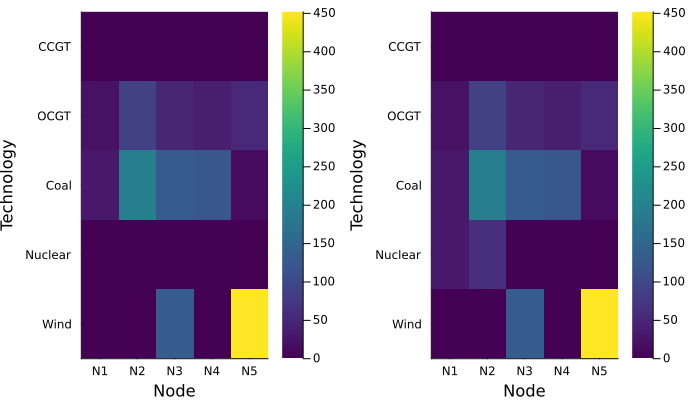

In [21]:
p1 = heatmap(["N$i" for i =1:5], ["Wind", "Nuclear", "Coal", "OCGT", "CCGT"], round.(sol_p_max_det, digits=2),
    ylabel = "Technology", 
    xlabel = "Node", 
    colormap=:viridis,
    size = (300,300))

p2 = heatmap(["N$i" for i =1:5], ["Wind", "Nuclear", "Coal", "OCGT", "CCGT"], round.(sol_p_max_det .+ GCN, digits=2),
ylabel = "Technology", 
xlabel = "Node", 
colormap=:viridis,
size = (300,300))

 plot(p1, p2, layout=(1,2), size = (700,400))


In [22]:
println("Transmission capacities installed: ")    # l
edges = Dict(L .=> round.(sol_f_max_det, digits=2))

Transmission capacities installed: 


Dict{Vector{Int64}, Float64} with 10 entries:
  [2, 3] => 14.29
  [1, 3] => 7.62
  [2, 5] => 0.0
  [2, 4] => 0.0
  [1, 5] => 0.0
  [1, 4] => 2.39
  [3, 5] => 17.72
  [1, 2] => 3.14
  [3, 4] => 0.0
  [4, 5] => 24.38

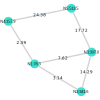

In [24]:
using Graphs, GraphPlot

g = Graph()
add_vertices!(g, 5)

edgelabel = []
for l in L
    if edges[l] >= 0.01 
        add_edge!(g, l[1], l[2])
        push!(edgelabel, edges[l])
    end
end

generation_per_node = sum(sol_p_max_det .+ GCN, dims = 1)

nodelabel = [string("N$i:",round.(generation_per_node[i],digits=1)) for i=1:5]
gplot(g, nodelabel=nodelabel, edgelabel = edgelabel)

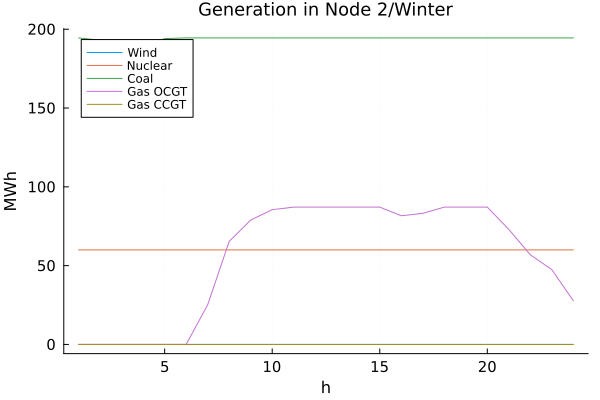

In [25]:
plot([sol_p_det[t,:,2,1] for t in 1:5],
        xtickfontsize=10,ytickfontsize=10,titlefontsize = 12,
        gridlinewidth = 0.1,
        xlabel = "h",
        ylabel = "MWh",
        label =["Wind" "Nuclear" "Coal" "Gas OCGT" "Gas CCGT"],
        title = "Generation in Node 2/Winter"
    )

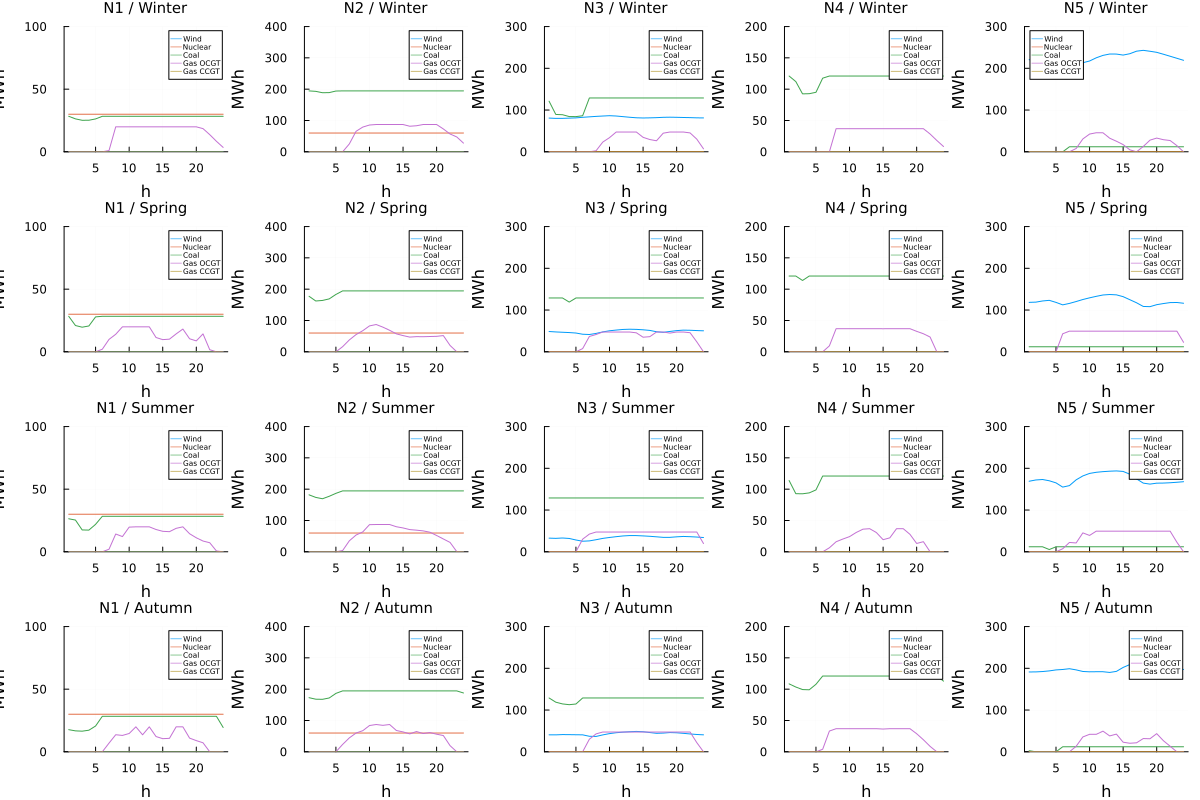

In [26]:
p = Array{Any}(undef,(5,4))
for i in 1:5, j in 1:4
    p[i,j] = plot([sol_p_det[t,:,i,j] for t in 1:5],
        legend = (i != 5 && j != 4) ? false : true,
        size = (1200,800),
        xtickfontsize=8,ytickfontsize=8,titlefontsize = 10,
        ylims = (0, max_load[i]),
        gridlinewidth = 0.1,
        xlabel = "h",
        ylabel = "MWh"
    )
    n = ["N1","N2","N3","N4","N5"][i]
    s = ["Winter","Spring","Summer","Autumn"][j]
    title!("$n / $s")
    # hline!([0],line = (:white, 1))
    if i == 2 || i == 3 || i == 5
        yticks!(0:100:max_load[i])
    else
        yticks!(0:50:max_load[i])
    end
end

plot(p..., layout = (4,5), label =["Wind" "Nuclear" "Coal" "Gas OCGT" "Gas CCGT"], legend=true, legendfontsize=5)

In [27]:
println("Hourly price statistics:")
println("- Mean price per MWh: ", round(mean(dual_det), digits = 2))
println("- Standard deviation of the price per MWh: ", round(std(dual_det), digits=2))
println("- Max price per MWh: ", round(maximum(dual_det), digits = 2))

Hourly price statistics:
- Mean price per MWh: 2.82
- Standard deviation of the price per MWh: 2.43
- Max price per MWh: 21.15


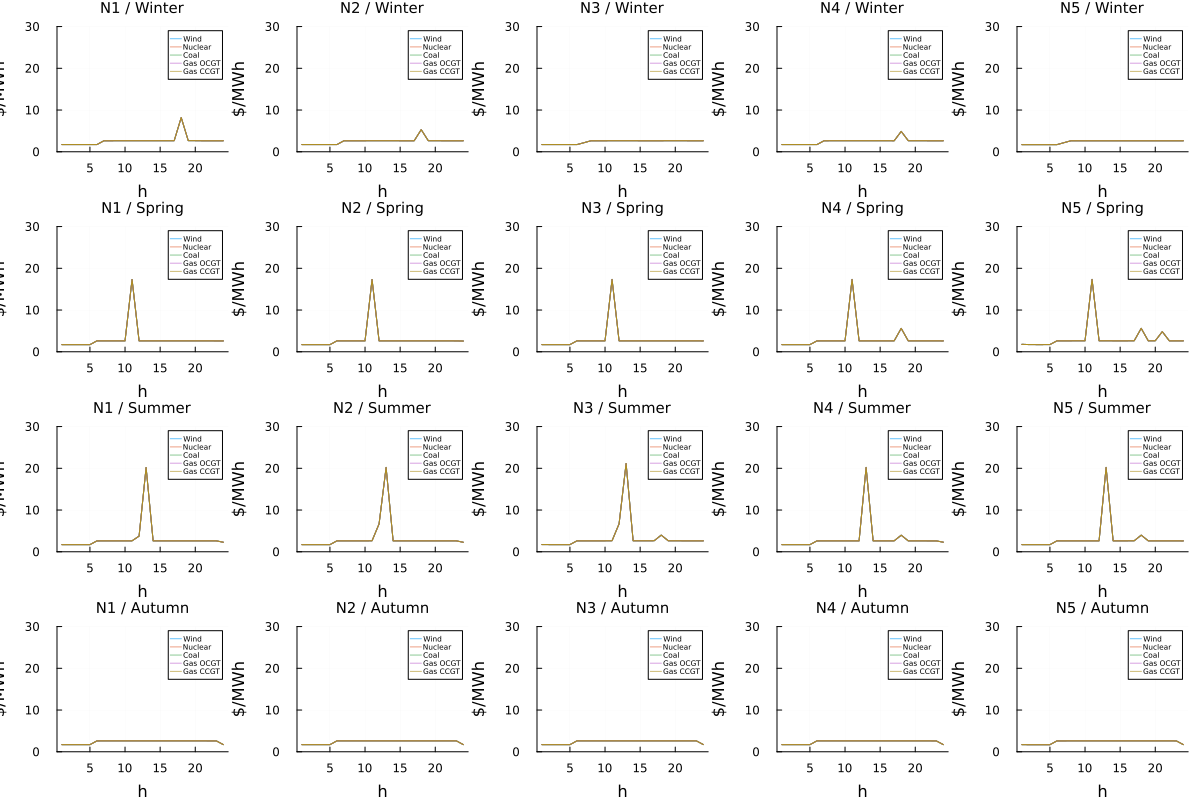

In [28]:
p = Array{Any}(undef,(5,4))
for i in 1:5, j in 1:4
    p[i,j] = plot([dual_det[:,i,j] for t in 1:5],
        legend = (i != 5 && j != 4) ? false : true,
        size = (1200,800),
        xtickfontsize=8,ytickfontsize=8,titlefontsize = 10,
        ylims = (0, 30),
        gridlinewidth = 0.1,
        xlabel = "h",
        ylabel = "\$/MWh"
    )
    n = ["N1","N2","N3","N4","N5"][i]
    s = ["Winter","Spring","Summer","Autumn"][j]
    title!("$n / $s")
end

plot(p..., layout = (4,5), label =["Wind" "Nuclear" "Coal" "Gas OCGT" "Gas CCGT"], legend=true, legendfontsize=5)